# Clustering Algorithms - K-Means, GMM, Bisecting K-Means

Code written by - Malmurugan Sukumar ( Student ID: 862246504)

In this notebook we implement clustering algorithms to group and 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import warnings
import os
from csv import reader
import time

In [2]:
import folium
from folium.plugins import MarkerCluster

In [3]:
from geopandas import GeoDataFrame
from shapely.geometry import Point

In [4]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

In [5]:
from pyspark.sql import Row 
from pyspark.sql import SparkSession
from pyspark.sql.types import FloatType, BooleanType
from pyspark.sql.functions import to_timestamp, concat, lit, udf, upper, to_timestamp, to_date

In [6]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.clustering import GaussianMixture
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.clustering import BisectingKMeans

## Loading the data

In [7]:
spark = SparkSession \
    .builder \
    .appName("crime analysis") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [8]:
startTime = time.time()

df = spark.read.format("csv").option("header", "true").load("Crime_Data_from_2010_to_2019.csv")

executionTime = (time.time() - startTime)
print('Time to load data in Spark: ' + str(executionTime))

Time to load data in Spark: 2.7048656940460205


In [9]:
df2 = df[["DR_NO", "Date Rptd","TIME OCC","Crm Cd Desc","LAT","LON","AREA NAME"]]
df2 = df2.withColumnRenamed("AREA NAME","AREANAME")

In [10]:
df2_new = df2[(df2.AREANAME  == "77th Street") | (df2.AREANAME  == "Southwest") | (df2.AREANAME  == "N Hollywood")]

In [11]:
df_lat = df2_new.select (df.LAT.cast("float"), df.LON.cast("float"))
df_lat = df_lat.where(df_lat['LAT']!=0.0)
df_lat = df_lat.where(df_lat['LON']!=0.0)

In [12]:
df_lat.createTempView("la_crime1")

In [13]:
df_f = spark.sql("SELECT LAT, LON FROM la_crime1")

## Transforming and Scaling the inputs

In [14]:
assembler = VectorAssembler(inputCols = df_f.columns, outputCol="features")
assembled = assembler.transform(df_f)

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)
scaler_model = scaler.fit(assembled)
assembled = scaler_model.transform(assembled)

## K Means Clustering - Elbow Method

In this section, we will use K-Means clustering to finlaize the number of clusters (K) with <b> Elbow Method </b>

In [15]:
cost = np.zeros(10)
for k in range(2,10):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("scaledFeatures")
    model = kmeans.fit(assembled.sample(False,0.1, seed=42))
    cost[k] = model.summary.trainingCost 

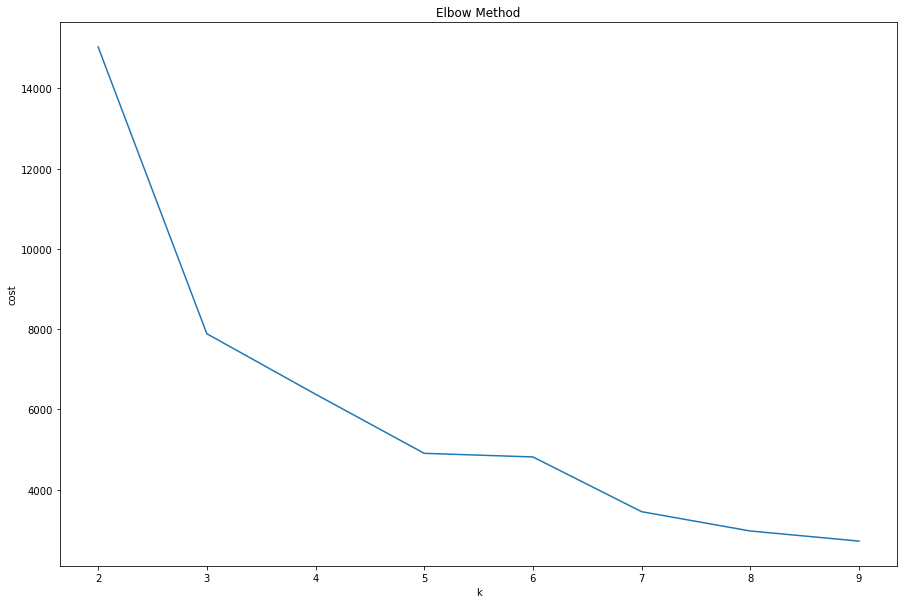

In [16]:
fig, ax = plt.subplots(figsize =(15,10))
ax.plot(range(2,10),cost[2:10])
ax.set_xlabel('k')
ax.set_ylabel('cost')
ax.set_title("Elbow Method")
plt.show()

The elbow point is at 3, so we finalize K = 3 for all our algorithms

## K-Means Clustering

In [17]:
startTime = time.time()
kmeans = KMeans().setK(3).setSeed(1)
model0 = kmeans.fit(assembled)

# Make predictions
predictions0 = model0.transform(assembled)
executionTime = (time.time() - startTime)
print('Execution time for Kmeans: ' + str(executionTime))

Execution time for Kmeans: 7.836184024810791


In [18]:
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions0)
print(str(silhouette))

0.6764917364762102


In [19]:
centers = model0.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[  33.97742605 -118.29232467]
[  34.17271887 -118.38574691]
[  34.01544115 -118.32087905]


In [20]:
pt1 = [  33.97742605, -118.29232467]
pt2 = [  34.17271887, -118.38574691]
pt3 = [  34.01544115, -118.32087905]

In [21]:
df_class_0 = predictions0.where(predictions0['prediction']==0)
df_class_1 = predictions0.where(predictions0['prediction']==1)
df_class_2 = predictions0.where(predictions0['prediction']==2)

df_class_0_pd = df_class_0.toPandas()
df_class_1_pd = df_class_1.toPandas()
df_class_2_pd = df_class_2.toPandas()

geometry0 = [Point(xy) for xy in zip(df_class_0_pd.LON, df_class_0_pd.LAT)]
geometry1 = [Point(xy) for xy in zip(df_class_1_pd.LON, df_class_1_pd.LAT)]
geometry2 = [Point(xy) for xy in zip(df_class_2_pd.LON, df_class_2_pd.LAT)]

gdf0 = GeoDataFrame(df_class_0_pd, crs="EPSG:4326", geometry=geometry0)
gdf1 = GeoDataFrame(df_class_1_pd, crs="EPSG:4326", geometry=geometry1)
gdf2 = GeoDataFrame(df_class_2_pd, crs="EPSG:4326", geometry=geometry2)
poly0 = gdf0.unary_union.convex_hull
poly1 = gdf1.unary_union.convex_hull
poly2 = gdf2.unary_union.convex_hull

In [22]:
coords = [  34.03978986, -118.2734079 ]

my_map0 = folium.Map(location = coords, zoom_start = 8)

folium.Marker(pt1, popup = 'pt1').add_to(my_map0)
folium.Marker(pt2, popup = 'pt2').add_to(my_map0)
folium.Marker(pt3, popup = 'pt3').add_to(my_map0)

In [23]:
folium.GeoJson(poly0).add_to(my_map0)
folium.GeoJson(poly1).add_to(my_map0)
folium.GeoJson(poly2).add_to(my_map0)

In [24]:
my_map0

## Gaussian Mixture Model

In [25]:
startTime = time.time()
gmm = GaussianMixture().setK(4).setSeed(1)
model1 = gmm.fit(assembled)


# Make predictions
predictions1 = model1.transform(assembled)
executionTime = (time.time() - startTime)
print('Execution time for GMM: ' + str(executionTime))

Execution time for GMM: 18.486242532730103


In [26]:
df_class_0 = predictions1.where(predictions1['prediction']==0)
df_class_1 = predictions1.where(predictions1['prediction']==1)
df_class_2 = predictions1.where(predictions1['prediction']==2)

df_class_0_pd = df_class_0.toPandas()
df_class_1_pd = df_class_1.toPandas()
df_class_2_pd = df_class_2.toPandas()

geometry0 = [Point(xy) for xy in zip(df_class_0_pd.LON, df_class_0_pd.LAT)]
geometry1 = [Point(xy) for xy in zip(df_class_1_pd.LON, df_class_1_pd.LAT)]
geometry2 = [Point(xy) for xy in zip(df_class_2_pd.LON, df_class_2_pd.LAT)]

gdf0 = GeoDataFrame(df_class_0_pd, crs="EPSG:4326", geometry=geometry0)
gdf1 = GeoDataFrame(df_class_1_pd, crs="EPSG:4326", geometry=geometry1)
gdf2 = GeoDataFrame(df_class_2_pd, crs="EPSG:4326", geometry=geometry2)
poly0 = gdf0.unary_union.convex_hull
poly1 = gdf1.unary_union.convex_hull
poly2 = gdf2.unary_union.convex_hull

In [27]:
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions1)
print(str(silhouette))

0.47246056944934134


In [28]:
coords = [  34.03978986, -118.2734079 ]

my_map1 = folium.Map(location = coords, zoom_start = 8)

In [29]:
folium.GeoJson(poly0).add_to(my_map1)
folium.GeoJson(poly1).add_to(my_map1)
folium.GeoJson(poly2).add_to(my_map1)

my_map1

# Bisecting K-Means

In [30]:
startTime = time.time()
b_kmeans = BisectingKMeans().setK(3).setSeed(1)
model2 = b_kmeans.fit(assembled)

# Make predictions
predictions2 = model2.transform(assembled)
executionTime = (time.time() - startTime)
print('Execution time for Bisecting Kmeans: ' + str(executionTime))

Execution time for Bisecting Kmeans: 15.24085807800293


In [31]:
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions2)
print(str(silhouette))

0.6765367997424712


In [32]:
centers = model2.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[  34.01549459 -118.32095318]
[  33.97752634 -118.29236074]
[  34.17271887 -118.38574691]


In [33]:
pt1_1 = [34.01549459, -118.32095318]
pt2_1 = [33.97752634, -118.29236074]
pt3_1 = [34.17271887, -118.38574691]

In [34]:
df_class_0 = predictions2.where(predictions2['prediction']==0)
df_class_1 = predictions2.where(predictions2['prediction']==1)
df_class_2 = predictions2.where(predictions2['prediction']==2)

df_class_0_pd = df_class_0.toPandas()
df_class_1_pd = df_class_1.toPandas()
df_class_2_pd = df_class_2.toPandas()

geometry0 = [Point(xy) for xy in zip(df_class_0_pd.LON, df_class_0_pd.LAT)]
geometry1 = [Point(xy) for xy in zip(df_class_1_pd.LON, df_class_1_pd.LAT)]
geometry2 = [Point(xy) for xy in zip(df_class_2_pd.LON, df_class_2_pd.LAT)]

gdf0 = GeoDataFrame(df_class_0_pd, crs="EPSG:4326", geometry=geometry0)
gdf1 = GeoDataFrame(df_class_1_pd, crs="EPSG:4326", geometry=geometry1)
gdf2 = GeoDataFrame(df_class_2_pd, crs="EPSG:4326", geometry=geometry2)
poly0 = gdf0.unary_union.convex_hull
poly1 = gdf1.unary_union.convex_hull
poly2 = gdf2.unary_union.convex_hull

In [35]:
coords = [  34.03978986, -118.2734079 ]

my_map2 = folium.Map(location = coords, zoom_start = 8)

folium.GeoJson(poly0).add_to(my_map2)
folium.GeoJson(poly1).add_to(my_map2)
folium.GeoJson(poly2).add_to(my_map2)

folium.Marker(pt1_1, popup = 'pt1').add_to(my_map2)
folium.Marker(pt2_1, popup = 'pt2').add_to(my_map2)
folium.Marker(pt3_1,popup = 'pt3').add_to(my_map2)


In [36]:
my_map2

## Implementing Models with Pandas for comparision

<b>Note: All operations following this will be solely used to compare execution time of PySpark MLib with Pandas ML library.<b>

In [38]:
startTime = time.time()

crime_df = pd.read_csv('Crime_Data_from_2010_to_2019.csv')

executionTime = (time.time() - startTime)
print('Time to load Data in Pandas: ' + str(executionTime))

Time to load Data in Pandas: 9.48651933670044


In [39]:
crime_df

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,...,Status,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON
0,1307355,02/20/2010 12:00:00 AM,02/20/2010 12:00:00 AM,1350,13,Newton,1385,2,900,VIOLATION OF COURT ORDER,...,AA,Adult Arrest,900.0,NaN,NaN,NaN,300 E GAGE AV,NaN,33.9825,-118.2695
1,11401303,09/13/2010 12:00:00 AM,09/12/2010 12:00:00 AM,45,14,Pacific,1485,2,740,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",...,IC,Invest Cont,740.0,NaN,NaN,NaN,SEPULVEDA BL,MANCHESTER AV,33.9599,-118.3962
2,70309629,08/09/2010 12:00:00 AM,08/09/2010 12:00:00 AM,1515,13,Newton,1324,2,946,OTHER MISCELLANEOUS CRIME,...,IC,Invest Cont,946.0,NaN,NaN,NaN,1300 E 21ST ST,NaN,34.0224,-118.2524
3,90631215,01/05/2010 12:00:00 AM,01/05/2010 12:00:00 AM,150,6,Hollywood,646,2,900,VIOLATION OF COURT ORDER,...,IC,Invest Cont,900.0,998.0,NaN,NaN,CAHUENGA BL,HOLLYWOOD BL,34.1016,-118.3295
4,100100501,01/03/2010 12:00:00 AM,01/02/2010 12:00:00 AM,2100,1,Central,176,1,122,"RAPE, ATTEMPTED",...,IC,Invest Cont,122.0,NaN,NaN,NaN,8TH ST,SAN PEDRO ST,34.0387,-118.2488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2119792,190506304,02/22/2019 12:00:00 AM,02/22/2019 12:00:00 AM,840,5,Harbor,569,2,627,CHILD ABUSE (PHYSICAL) - SIMPLE ASSAULT,...,AO,Adult Other,627.0,NaN,NaN,NaN,100 W 22ND ST,NaN,33.7257,-118.2801
2119793,190608903,03/28/2019 12:00:00 AM,03/28/2019 12:00:00 AM,400,6,Hollywood,644,1,648,ARSON,...,IC,Invest Cont,648.0,NaN,NaN,NaN,1400 N LA BREA AV,NaN,34.0962,-118.3490
2119794,192004409,01/06/2019 12:00:00 AM,01/06/2019 12:00:00 AM,2100,20,Olympic,2029,2,930,CRIMINAL THREATS - NO WEAPON DISPLAYED,...,IC,Invest Cont,930.0,NaN,NaN,NaN,6TH,VIRGIL,34.0637,-118.2870
2119795,191716777,10/17/2019 12:00:00 AM,10/16/2019 12:00:00 AM,1800,17,Devonshire,1795,1,420,THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER),...,IC,Invest Cont,420.0,NaN,NaN,NaN,17200 NAPA ST,NaN,34.2266,-118.5085


In [40]:
crime_df = crime_df[["DR_NO", "Date Rptd","TIME OCC","Crm Cd Desc","LAT","LON","AREA NAME"]]

In [41]:
crime_df = crime_df.rename(columns = {"AREA NAME":"AREANAME"})

In [42]:
crime_df = crime_df[(crime_df.AREANAME  == "77th Street") | (crime_df.AREANAME  == "Southwest") | (crime_df.AREANAME  == "N Hollywood")]

In [43]:
(crime_df[crime_df.AREANAME == "77th Street"].shape[0]) +(crime_df[crime_df.AREANAME == "Southwest"].shape[0]) + (crime_df[crime_df.AREANAME == "N Hollywood"].shape[0]) 

395458

In [44]:
crime_df = crime_df[(crime_df.LON!=0.0) | (crime_df.LAT!=0.0)]

In [45]:
crime_latlong = crime_df[['LAT','LON']]

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import sklearn
from sklearn.mixture import GaussianMixture

### K Means Algortihm using Pandas Library

In [47]:
model = KMeans(n_clusters=3)
kmeans = model.fit(crime_latlong)
centroids = kmeans.cluster_centers_
print(centroids)

[[  34.17271894 -118.3857469 ]
 [  34.01549486 -118.32095373]
 [  33.97752686 -118.29236076]]


In [48]:
startTime = time.time()

model = KMeans(n_clusters=3)
kmeans = model.fit(crime_latlong)
predictions = kmeans.predict(crime_latlong)

executionTime = (time.time() - startTime)

print('Execution time for Kmeans in Pandas: ' + str(executionTime))

Execution time for Kmeans in Pandas: 2.0149924755096436


### Gaussian Mixture Model Algortihm using Pandas Library

In [49]:

startTime = time.time()


GMM = GaussianMixture(n_components=3, random_state=0).fit(crime_latlong)
gmm_pred = GMM.predict(crime_latlong)

executionTime = (time.time() - startTime)
print('Execution time for Gaussian Mixture in Pandas: ' + str(executionTime))

Execution time for Gaussian Mixture in Pandas: 2.2787320613861084


### Bisecting K Means Algortihm using Pandas Library

In [50]:
startTime = time.time()

model = KMeans(init='k-means++',n_clusters=3)
bikmeans = model.fit(crime_latlong)
predictions = bikmeans.predict(crime_latlong)

executionTime = (time.time() - startTime)

print('Execution time for Bisecting KMeans in Pandas: ' + str(executionTime))

Execution time for Bisecting KMeans in Pandas: 2.161618232727051
